<a href="https://colab.research.google.com/github/piramid/AI-on-the-edge-device/blob/master/RealTimeHumanActivityRecognitionLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**RealTimeHumanActivityRecognitionLSTM**
 https://www.youtube.com/watch?v=PWMlR8eVgHc&t=400s

In [1]:
!pip install tensorflow==1.14

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 65 kB/s 
     |████████████████████████████████| 488 kB 76.7 MB/s 
     |████████████████████████████████| 3.1 MB 65.1 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
ERROR: pip's dependency resolver does not currently ta

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.5 )

RANDOM_SEED = 42

from google.colab import drive

drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Mounted at /content/drive


**Ensuring data is properly loaded**

In [3]:
columns = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('/content/drive/MyDrive/WISD_HAR/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df = df.dropna()
df.head()
#df.tail()
#daac = df.timestamp.sample(n=5000)
#daac
#df = df[['user','activity','timestamp','x-axis','y-axis','z-axis']].sample(n=50000)
#df

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [4]:
df.tail()

,user,activity,timestamp,x-axis,y-axis,z-axis
1098199,19,Sitting,131623331483000,9.00,-1.57,1.69
1098200,19,Sitting,131623371431000,9.04,-1.46,1.73
1098201,19,Sitting,131623411592000,9.08,-1.38,1.69
1098202,19,Sitting,131623491487000,9.00,-1.46,1.73
1098203,19,Sitting,131623531465000,8.88,-1.33,1.61


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x-axis     1098203 non-null  float64
 4   y-axis     1098203 non-null  float64
 5   z-axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


Exploration

In [6]:
countOfActivity = df['activity'].value_counts()
print(countOfActivity)

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64


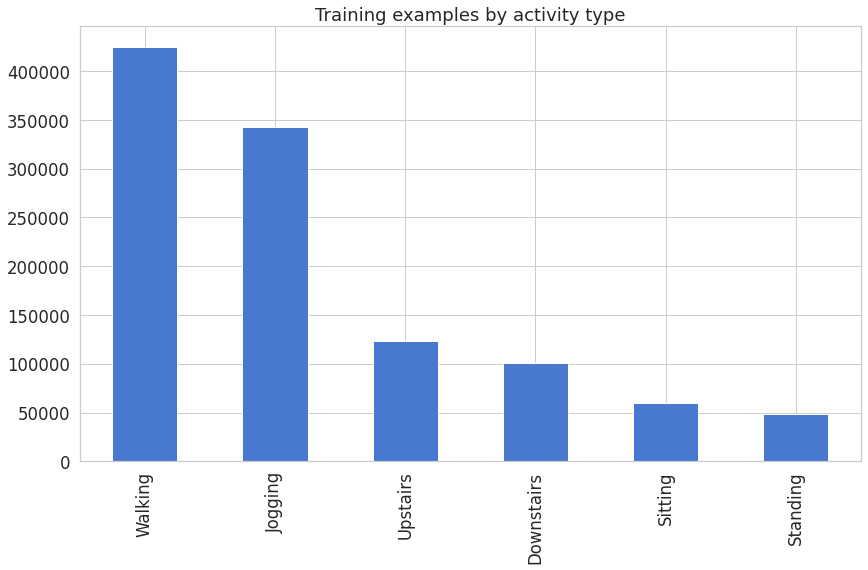

In [7]:
countOfActivity.plot(kind = 'bar', title = 'Training examples by activity type', figsize = (14,8));

No of samples belonging to each volunteer:
The columns we will be most interested in areactivity, x-axis, y-axis, z-axis, Let's drive into data

In [8]:
#from numpy.ma.core import count
countOfActivityPerPerson = df['user'].value_counts()
print(countOfActivityPerPerson)
totalActivity = countOfActivityPerPerson.sum() #summation of all activities of all test persons
print("Total Number of Activity Records = "+str(totalActivity))

20    56632
19    45383
31    44282
8     41188
29    38245
14    38192
13    37093
34    35947
32    35506
21    35436
3     35161
27    34958
10    34883
18    32811
12    32641
26    32578
36    32261
11    31658
7     30967
1     29978
6     29704
33    29453
5     28509
15    28154
24    25736
23    25673
30    25335
2     23525
35    22394
22    22310
17    22020
28    21358
16    20470
25    13468
9     12923
4     11371
Name: user, dtype: int64
Total Number of Activity Records = 1098203


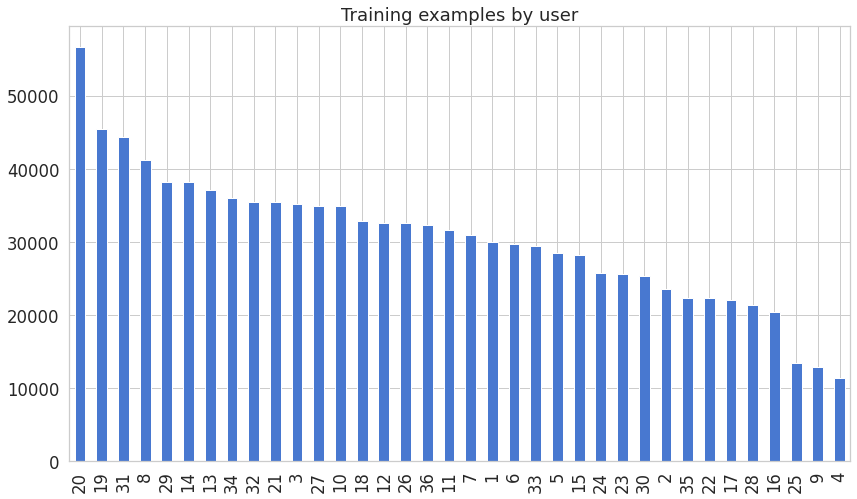

In [9]:
countOfActivityPerPerson.plot(kind = 'bar', title = "Training examples by user", figsize = (14,8))

**How does accelerometer data looks like visually**

In [10]:
def plot_activity(activity, df):
  extractRowsOfActivity = (df['activity']==activity) #output will be true/false
  data = df[extractRowsOfActivity] #it will give only rows coressponding to specific activity
  data = data[['x-axis','y-axis','z-axis']] #only select rows coressponding to x, y and z axis
  data = data[:200] #limit the number of rows to initial 200 for plotting

  ax = data.plot(subplots=True, figsize=(16, 12), title=activity) #plotting invidual column of data frame

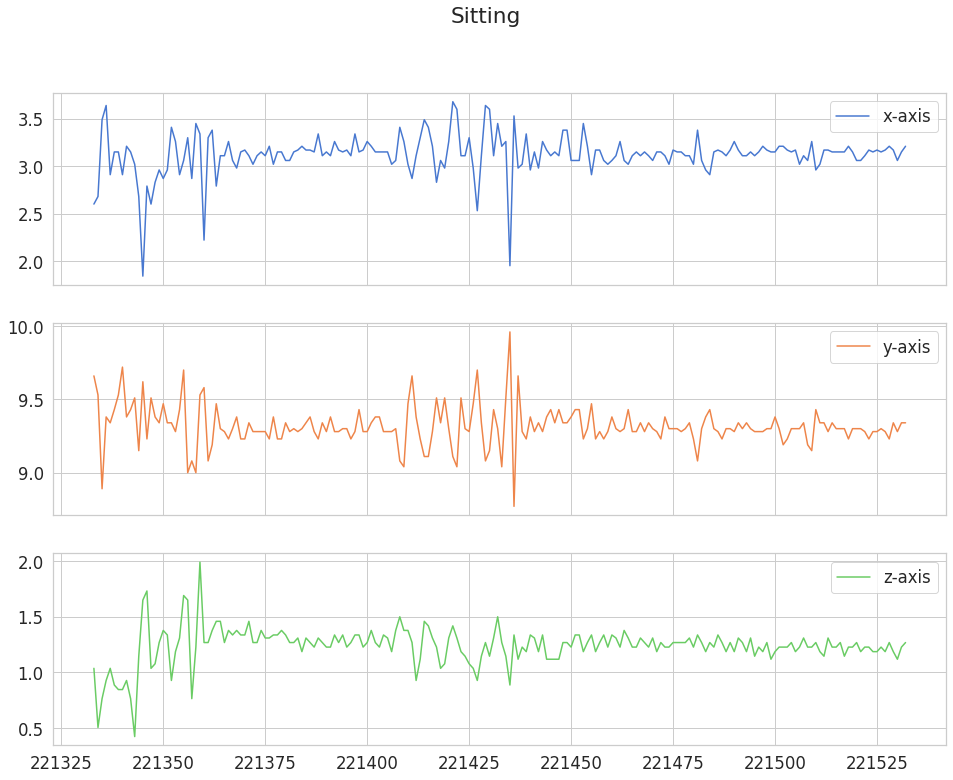

In [11]:
plot_activity("Sitting", df)

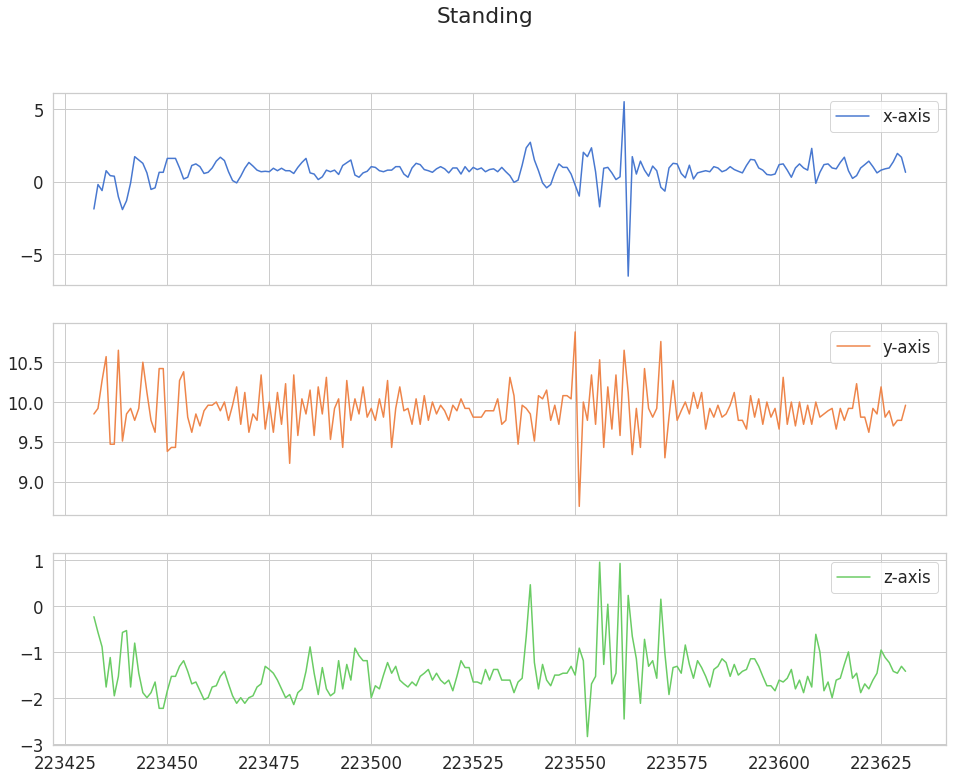

In [12]:
plot_activity("Standing", df)

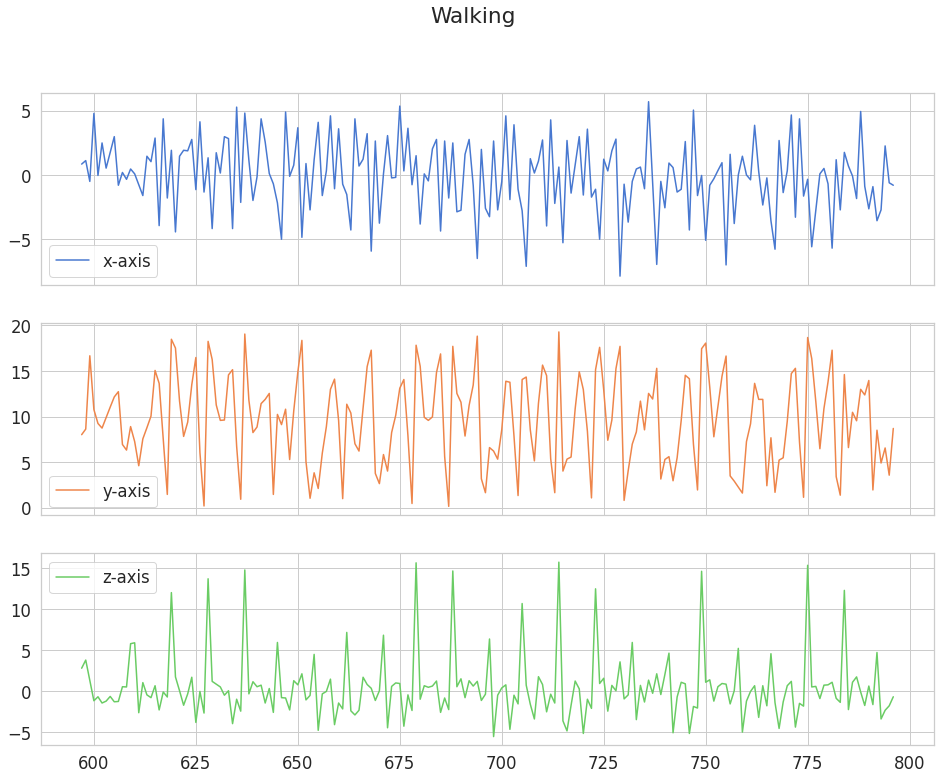

In [13]:
plot_activity("Walking", df)

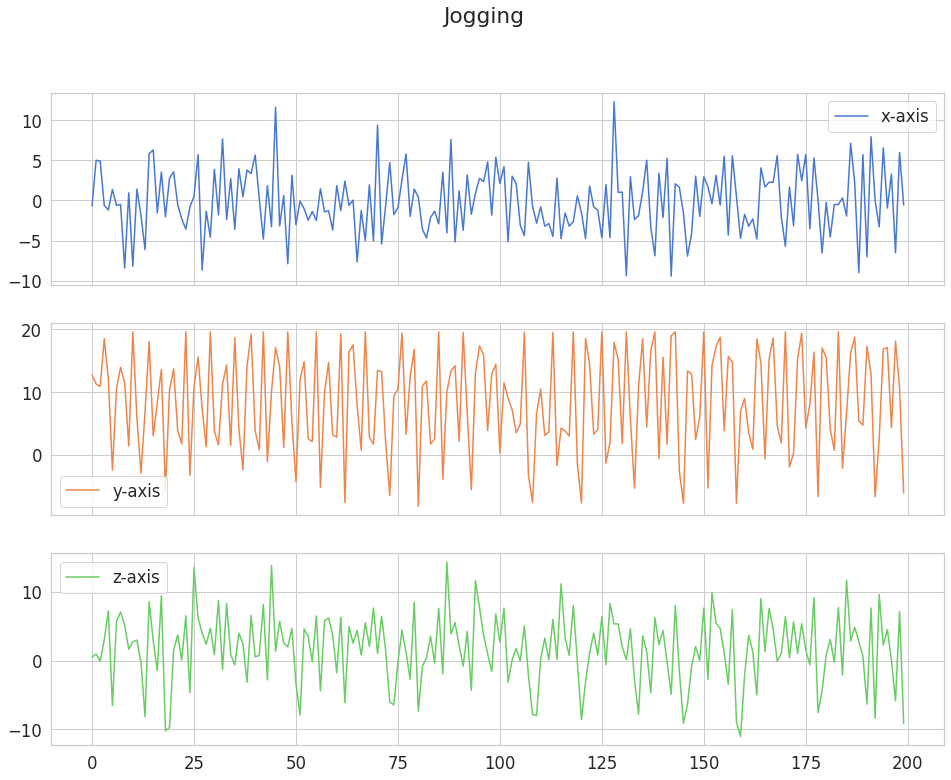

In [14]:
plot_activity("Jogging", df)

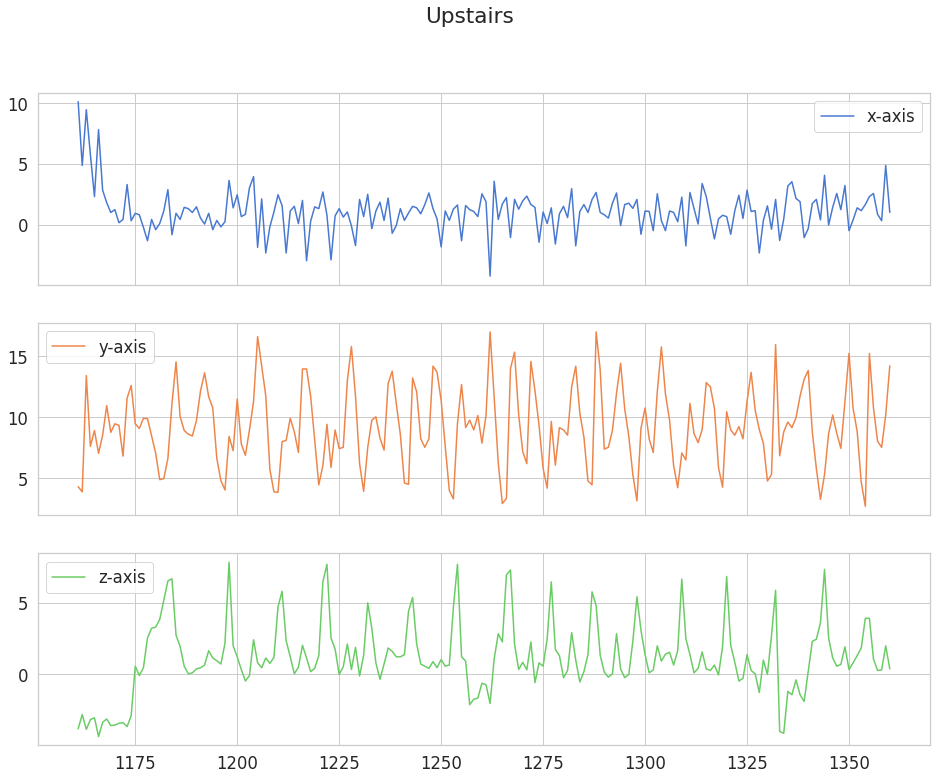

In [15]:
plot_activity("Upstairs", df)

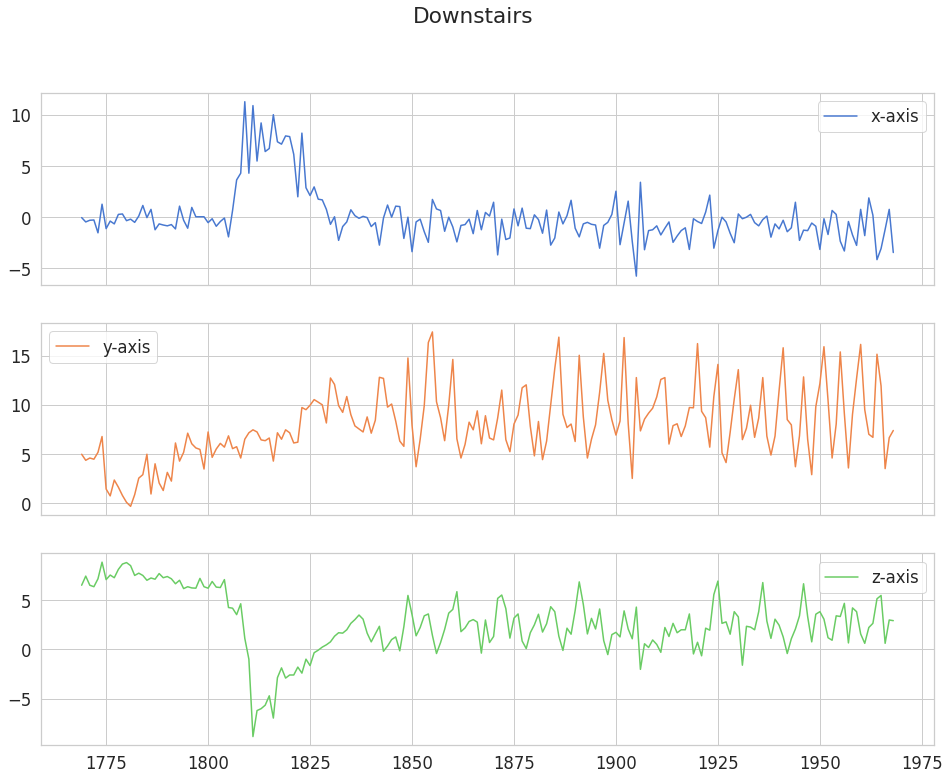

In [16]:
plot_activity("Downstairs", df)

Data Processiong
- Modelling time series
- LSTM RNN
- 200 training sample sequence
- Dividing the whole data into multiple time slice

In [17]:
N_TIME_STEPS = 200   # 200
N_FEATURES = 3          # 3
step = 20                     # 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):   #will give starting point of each batch
   xs = df['x-axis'].values[i: i+N_TIME_STEPS]
   ys = df['y-axis'].values[i: i+N_TIME_STEPS]
   zs = df['z-axis'].values[i: i+N_TIME_STEPS]
   label = stats.mode(df['activity'][i:i+N_TIME_STEPS]) #return two arrays mode and count
   label = label[0][0] #to get actual value of mode
   segments.append([xs, ys, zs])
   labels.append(label)

In [18]:
np.array(segments).shape

(54901, 3, 200)

**Transforming shape of segments**

In [19]:
reshaped_segment = np.array(segments, dtype = np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
reshaped_segment.shape

(54901, 200, 3)

**One hot Encoding of label (Walking, Sitting, Jogging etc.)**

In [20]:
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32) # pd.getdummies is use for one hot encoding

In [21]:
print(labels)
print(labels.shape)

[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
(54901, 6)


**Finally, let's split the data into training and test (20%) set**

In [22]:
x_train, x_test, y_train, y_test = train_test_split(
    reshaped_segment, labels, test_size=0.2, random_state=RANDOM_SEED
)

In [23]:
len(x_train)

43920

In [24]:
len(x_test)

10981

**Building the model**
- 2 fully-connected and 2 LSTM layers
- 64 units each

In [25]:
N_CLASSES = 6
N_HIDDEN_UNIT = 64 # LSTM layers 64

In [26]:
def create_LSTM_model(inputs):
  W = {
      'hidden' : tf.Variable(tf.random.normal([N_FEATURES, N_HIDDEN_UNIT])),    # 3*64
       'output' : tf.Variable(tf.random.normal([N_HIDDEN_UNIT, N_CLASSES]))       # 64*6
  }
  biases = {
      'hidden' : tf.Variable(tf.random.normal([N_HIDDEN_UNIT], mean=1.0)),        # 64
      'output' : tf.Variable(tf.random.normal([N_CLASSES]))                                  # 6
  }

  X = tf.transpose(inputs, [1, 0, 2])
  X = tf.reshape(X, [-1, N_FEATURES])
  hidden = tf.nn.relu(tf.matmul(X, W['hidden'])+biases['hidden'])
  hidden = tf.split(hidden, N_TIME_STEPS, 0)

  #stack 2 LSTM layers
  lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNIT, forget_bias=1.0) for _ in range(2)] #create 2 LSTM Layers
  lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers) #stacks them

  outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32) #actually create a LSTM network out of LSTM Layers

  #Get output for last time step
  lstm_last_output = outputs[-1]

  return tf.matmul(lstm_last_output, W['output']) + biases['output']

**Creating the Placeholders**

In [27]:
#from tensorflow.python.framework import ops
#ops.reset_default_graph()
tf.reset_default_graph() #to clear default graph
#import tensorflow.compat.v1 as tf1
#tfv1.disable_v2_behavior() 

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name = "input") #X values that must be fed using feed dict
Y = tf.placeholder(tf.float32, [None, N_CLASSES]) # Y values that must be using fed dict

**Creatning the Model**

In [28]:
#import tensorflow as tf
pred_Y = create_LSTM_model(X)
pred_sofmax = tf.nn.softmax(pred_Y, name="y_")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


**Regularization and Loss Function**

In [29]:
from tensorflow.python.ops.gen_nn_ops import l2_loss
L2_LOSS = 0.0015
l2 = L2_LOSS * \
      sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels=Y)) + 12

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



**Optimizer and accuracy**

In [30]:
LEARNING_RATE = 0.0025
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)
correct_predict = tf.equal(tf.argmax(pred_sofmax, 1), tf.argmax(Y, 1)) #finding the highest probability prediction
accuracy = tf.reduce_mean(tf.cast(correct_predict, dtype=tf.float32))

**Training**

In [31]:
N_EPOCHS = 50 #50
BATCH_SIZE = 1024 #1024

In [32]:
saver = tf.train.Saver()
history = dict(train_loss=[],
               train_acc = [],
               test_loss = [],
               test_acc = [])
sess = tf.InteractiveSession() #create a session
sess.run(tf.global_variables_initializer())
train_count = len(x_train)

for i in range(1, N_EPOCHS + 1):
  for start, end in zip(range(0, train_count, BATCH_SIZE),
                              range(BATCH_SIZE, train_count + 1, BATCH_SIZE)): #this will give us upper and lower limit of each batch
    sess.run(optimizer, feed_dict={X: x_train[start:end], Y: y_train[start:end]})
    
    _, acc_train, loss_train = sess.run([pred_sofmax, accuracy, loss], feed_dict={X: x_train, Y: y_train})
    _, acc_test, loss_test = sess.run([pred_sofmax, accuracy, loss], feed_dict={X: x_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
      print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
  
predictions, acc_final, loss_final = sess.run([pred_sofmax, accuracy, loss], feed_dict={X: x_test, Y: y_test})
print()
print(f'final result: accuracy: {acc_final} loss: {loss_final}')




epoch: 2 test accuracy: 0.812221109867096 loss: 12.510575294494629
epoch: 2 test accuracy: 0.8089427351951599 loss: 12.501840591430664
epoch: 2 test accuracy: 0.8142245411872864 loss: 12.489235877990723
epoch: 2 test accuracy: 0.8253346681594849 loss: 12.474042892456055
epoch: 2 test accuracy: 0.8221473693847656 loss: 12.478652000427246
epoch: 2 test accuracy: 0.8249704241752625 loss: 12.481257438659668
epoch: 2 test accuracy: 0.7888170480728149 loss: 12.542189598083496
epoch: 2 test accuracy: 0.8158637881278992 loss: 12.521461486816406
epoch: 2 test accuracy: 0.8262453079223633 loss: 12.474713325500488
epoch: 2 test accuracy: 0.8126764297485352 loss: 12.503125190734863
epoch: 2 test accuracy: 0.8228758573532104 loss: 12.481395721435547
epoch: 2 test accuracy: 0.8218741416931152 loss: 12.498025894165039
epoch: 2 test accuracy: 0.8242418766021729 loss: 12.474067687988281
epoch: 2 test accuracy: 0.8166833519935608 loss: 12.503264427185059
epoch: 2 test accuracy: 0.8294326663017273 loss: 

**Save model to disk**

In [35]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.' , './checkpoint/har.pbtxt')
saver.save(sess, save_path= "./checkpoint/har.ckpt")
sess.close()

**And loading it back**

In [36]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

**Evaluation- Creating confusion matrix**

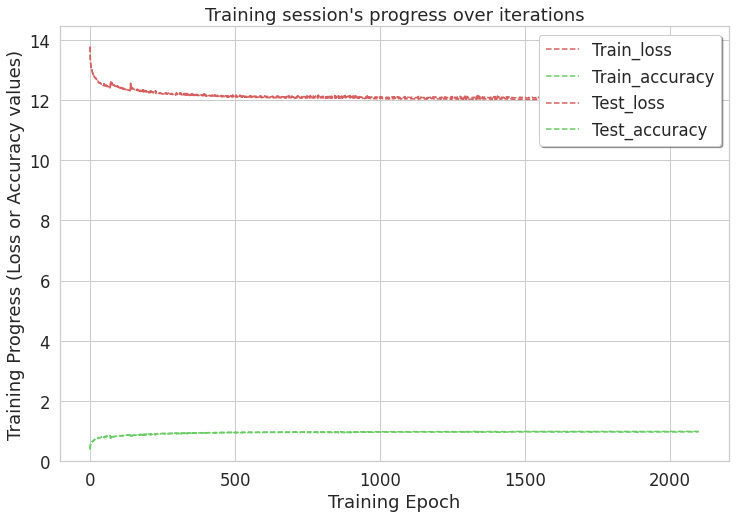

In [64]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train_loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train_accuracy")

plt.plot(np.array(history['test_loss']), "r--", label="Test_loss")
plt.plot(np.array(history['test_acc']), "g--", label="Test_accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc="upper right", shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [41]:
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Upstairs', 'Walking']

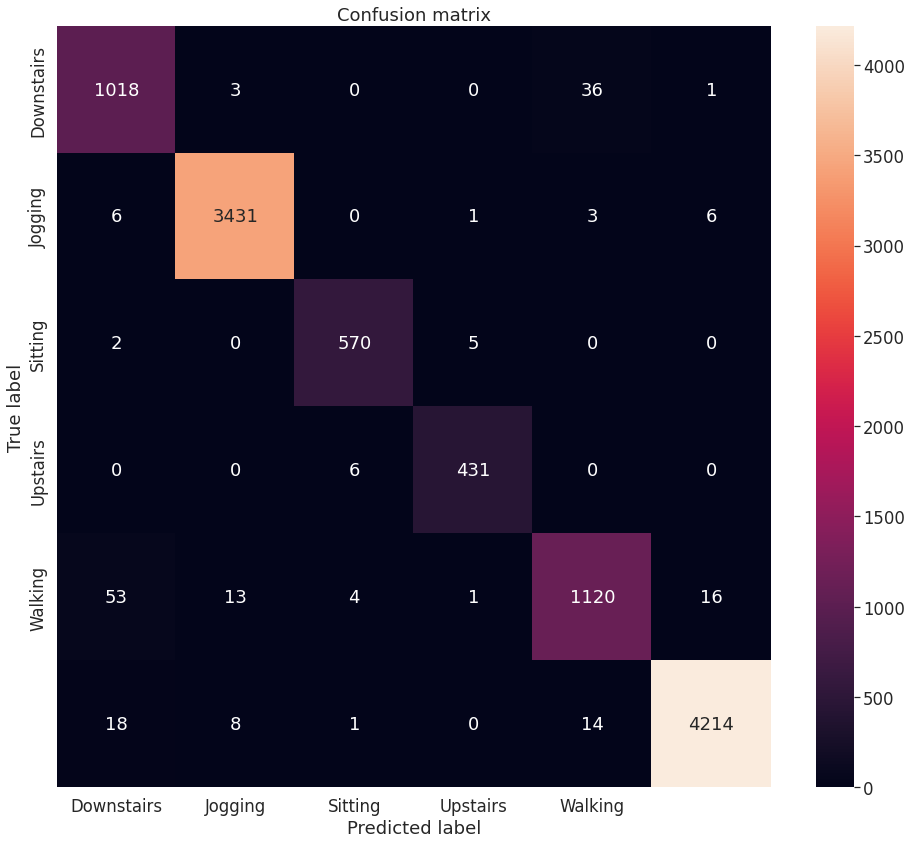

In [50]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show();

**Exporting model to android**

In [ ]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path,
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0",
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")